In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import scipy
from skimage import color
import tempfile
import os
from timeit import default_timer as timer
from tempfile import TemporaryFile
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process.kernels import WhiteKernel
from sklearn.gaussian_process.kernels import ExpSineSquared
import decimal
from decimal import *
from sklearn.gaussian_process.kernels import ConstantKernel
from numpy import loadtxt
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import keras
from sklearn.metrics import roc_auc_score
import glob
import pickle

In [2]:
#Function to load in picture data in the format (XxZ) and
#reshape it to (XxY, 1) and give them out in list format.
#Example path: '/bph/puredata1/raman/SP8 Leica/data/PD/skin/exported data/patient 15A, test slide 2/cut 1/ROI 1/HFR (2789-3011)'
#File ending determines the channel used for picture acquisition
#Example file ending: "ch00.tif"
#Pictures are also grayscaled
def Raw_Plus_Loader(Path, file_ending):
    
    path = Path
    os.chdir(path)
    directory = os.fsencode(path)
    
    sorted_dir = sorted(os.listdir(directory))
    raw_tif_data = []
    raw_data = []
    for file in sorted_dir:
        try:
            filename = os.fsdecode(file)
            if filename.endswith(file_ending):
                print("Reading image: " + filename)
                raw = plt.imread(filename)
                print(raw.shape)
                raw_data.append(raw)
                grayscaled_raw = color.rgb2gray(raw)
                
                raw_tif_data.append(grayscaled_raw)
        except ValueError:
            print('Not an image')
            continue
    
    #Reshaping to 2D
    Reshaped_picture_data = []
    
    for i in raw_tif_data:
        reshaped_data = np.array(np.reshape(i, [-1, 1]))
        print(reshaped_data.shape)
        Reshaped_picture_data.append(reshaped_data)
        
    del raw_tif_data
    return(Reshaped_picture_data, raw_data)

## Create a combined dataset of all Raman data associated with the corresponding label for aSyn-occurrence for each single pixel in every image

### 1) The first input is the autoregistration result , given as a so called "optislice"; that is the intensity information of a given aSyn-fluorescence image tile yielded by registering a Raman image tile with its corresponding fluorescence image
    This allows to associate Raman intensities of every pixel with the fluorescence information of the same pixel, indicating absence (0) or occurrence (1) of aSyn in that position.
### 2) The second input is the information from the Raman tile images across all measured wavenumbers (WN)
### 3) The third input is the needed aSyn-fluorescence image
    This image wil be binarized based on a certain threshold value, so that afterwards the pixels are only carrying binary information about the fluorescence state of a pixel; this is relevant as the aim is to train the the classifiers to differentiate between aSyn-occurrence and -absence and not to predict continuous fluorescence intensities.

In [3]:
P17_S10_C10_HFR_paths = ['/bph/puredata1/raman/SP8 Leica/data/PD/skin/Patient 17C/Slide10, cut10/SRS/Images/ROI6/HFR']
print(P17_S10_C10_HFR_paths)

['/bph/puredata1/raman/SP8 Leica/data/PD/skin/Patient 17C/Slide10, cut10/SRS/Images/ROI6/HFR']


In [4]:
P17_S10_C10_FP_paths = ['/bph/puredata1/raman/SP8 Leica/data/PD/skin/Patient 17C/Slide10, cut10/SRS/Images/ROI6/FP']
print(P17_S10_C10_FP_paths)

['/bph/puredata1/raman/SP8 Leica/data/PD/skin/Patient 17C/Slide10, cut10/SRS/Images/ROI6/FP']


In [5]:
P17_S10_C20_HFR_paths = ['/bph/puredata1/raman/SP8 Leica/data/PD/skin/Patient 17C/Slide10, cut20/SRS/Images/ROI1/HFR']
print(P17_S10_C20_HFR_paths)

['/bph/puredata1/raman/SP8 Leica/data/PD/skin/Patient 17C/Slide10, cut20/SRS/Images/ROI1/HFR']


In [6]:
P17_S10_C20_FP_paths = ['/bph/puredata1/raman/SP8 Leica/data/PD/skin/Patient 17C/Slide10, cut20/SRS/Images/ROI1/FP']
print(P17_S10_C20_FP_paths)

['/bph/puredata1/raman/SP8 Leica/data/PD/skin/Patient 17C/Slide10, cut20/SRS/Images/ROI1/FP']


In [7]:
P19_S6_C16_HFR_paths = ['/bph/puredata1/raman/SP8 Leica/data/PD/skin/Patient 19C/Slide6,cut16/SRS/Images/ROI1/HFR']
print(P19_S6_C16_HFR_paths)

['/bph/puredata1/raman/SP8 Leica/data/PD/skin/Patient 19C/Slide6,cut16/SRS/Images/ROI1/HFR']


In [8]:
P19_S6_C16_FP_paths = ['/bph/puredata1/raman/SP8 Leica/data/PD/skin/Patient 19C/Slide6,cut16/SRS/Images/ROI1/FP']
print(P19_S6_C16_FP_paths)

['/bph/puredata1/raman/SP8 Leica/data/PD/skin/Patient 19C/Slide6,cut16/SRS/Images/ROI1/FP']


In [9]:
P109_S20_C40_HFR_paths = ['/bph/puredata1/raman/SP8 Leica/data/PD/skin/Patient 109Ccontrol/Slide20, cut40/SRS/Images/ROI2/HFR',
                         '/bph/puredata1/raman/SP8 Leica/data/PD/skin/Patient 109Ccontrol/Slide20, cut40/SRS/Images/ROI3/HFR',
                         '/bph/puredata1/raman/SP8 Leica/data/PD/skin/Patient 109Ccontrol/Slide20, cut40/SRS/Images/ROI7/HFR']
print(P109_S20_C40_HFR_paths)

['/bph/puredata1/raman/SP8 Leica/data/PD/skin/Patient 109Ccontrol/Slide20, cut40/SRS/Images/ROI2/HFR', '/bph/puredata1/raman/SP8 Leica/data/PD/skin/Patient 109Ccontrol/Slide20, cut40/SRS/Images/ROI3/HFR', '/bph/puredata1/raman/SP8 Leica/data/PD/skin/Patient 109Ccontrol/Slide20, cut40/SRS/Images/ROI7/HFR']


In [10]:
P109_S20_C40_FP_paths = ['/bph/puredata1/raman/SP8 Leica/data/PD/skin/Patient 109Ccontrol/Slide20, cut40/SRS/Images/ROI2/FP',
                        '/bph/puredata1/raman/SP8 Leica/data/PD/skin/Patient 109Ccontrol/Slide20, cut40/SRS/Images/ROI3/FP',
                        '/bph/puredata1/raman/SP8 Leica/data/PD/skin/Patient 109Ccontrol/Slide20, cut40/SRS/Images/ROI7/FP']
print(P109_S20_C40_FP_paths)

['/bph/puredata1/raman/SP8 Leica/data/PD/skin/Patient 109Ccontrol/Slide20, cut40/SRS/Images/ROI2/FP', '/bph/puredata1/raman/SP8 Leica/data/PD/skin/Patient 109Ccontrol/Slide20, cut40/SRS/Images/ROI3/FP', '/bph/puredata1/raman/SP8 Leica/data/PD/skin/Patient 109Ccontrol/Slide20, cut40/SRS/Images/ROI7/FP']


In [11]:
P22_S14_C29_HFR_paths = ['/bph/puredata1/raman/SP8 Leica/data/PD/skin/Patient 22C/Slide14, cut29/SRS/Images/ROI3/HFR',
                    '/bph/puredata1/raman/SP8 Leica/data/PD/skin/Patient 22C/Slide14, cut29/SRS/Images/ROI4/HFR',
                    '/bph/puredata1/raman/SP8 Leica/data/PD/skin/Patient 22C/Slide14, cut29/SRS/Images/ROI8/HFR',
                    '/bph/puredata1/raman/SP8 Leica/data/PD/skin/Patient 22C/Slide14, cut29/SRS/Images/ROI9/HFR',
                    '/bph/puredata1/raman/SP8 Leica/data/PD/skin/Patient 22C/Slide14, cut29/SRS/Images/ROI10/HFR',
                    '/bph/puredata1/raman/SP8 Leica/data/PD/skin/Patient 22C/Slide14, cut29/SRS/Images/ROI12/HFR']
print(P22_S14_C29_HFR_paths)

['/bph/puredata1/raman/SP8 Leica/data/PD/skin/Patient 22C/Slide14, cut29/SRS/Images/ROI3/HFR', '/bph/puredata1/raman/SP8 Leica/data/PD/skin/Patient 22C/Slide14, cut29/SRS/Images/ROI4/HFR', '/bph/puredata1/raman/SP8 Leica/data/PD/skin/Patient 22C/Slide14, cut29/SRS/Images/ROI8/HFR', '/bph/puredata1/raman/SP8 Leica/data/PD/skin/Patient 22C/Slide14, cut29/SRS/Images/ROI9/HFR', '/bph/puredata1/raman/SP8 Leica/data/PD/skin/Patient 22C/Slide14, cut29/SRS/Images/ROI10/HFR', '/bph/puredata1/raman/SP8 Leica/data/PD/skin/Patient 22C/Slide14, cut29/SRS/Images/ROI12/HFR']


In [12]:
P22_S14_C29_FP_paths = ['/bph/puredata1/raman/SP8 Leica/data/PD/skin/Patient 22C/Slide14, cut29/SRS/Images/ROI3/FP',
                    '/bph/puredata1/raman/SP8 Leica/data/PD/skin/Patient 22C/Slide14, cut29/SRS/Images/ROI4/FP',
                    '/bph/puredata1/raman/SP8 Leica/data/PD/skin/Patient 22C/Slide14, cut29/SRS/Images/ROI8/FP',
                    '/bph/puredata1/raman/SP8 Leica/data/PD/skin/Patient 22C/Slide14, cut29/SRS/Images/ROI9/FP',
                    '/bph/puredata1/raman/SP8 Leica/data/PD/skin/Patient 22C/Slide14, cut29/SRS/Images/ROI10/FP',
                    '/bph/puredata1/raman/SP8 Leica/data/PD/skin/Patient 22C/Slide14, cut29/SRS/Images/ROI12/FP']
print(P22_S14_C29_FP_paths)

['/bph/puredata1/raman/SP8 Leica/data/PD/skin/Patient 22C/Slide14, cut29/SRS/Images/ROI3/FP', '/bph/puredata1/raman/SP8 Leica/data/PD/skin/Patient 22C/Slide14, cut29/SRS/Images/ROI4/FP', '/bph/puredata1/raman/SP8 Leica/data/PD/skin/Patient 22C/Slide14, cut29/SRS/Images/ROI8/FP', '/bph/puredata1/raman/SP8 Leica/data/PD/skin/Patient 22C/Slide14, cut29/SRS/Images/ROI9/FP', '/bph/puredata1/raman/SP8 Leica/data/PD/skin/Patient 22C/Slide14, cut29/SRS/Images/ROI10/FP', '/bph/puredata1/raman/SP8 Leica/data/PD/skin/Patient 22C/Slide14, cut29/SRS/Images/ROI12/FP']


In [13]:
Opt_path_P17_S10_C10 = ['/bph/puredata1/bioinfdata/user/phikie/Auto_reg_Results/P17C_S10C10_ROI6/Opti_slice_P17C_S10C10_ROI6.npy']

In [14]:
Opt_path_P17_S10_C20 = ['/bph/puredata1/bioinfdata/user/phikie/Auto_reg_Results/P17C_S10C20_ROI1/Opti_slice_P17C_S10C20_ROI1.npy']

In [15]:
Opt_path_P19_S6_C16 = ['/bph/puredata1/bioinfdata/user/phikie/Auto_reg_Results/P19C/P19C_S6_C16_ROI1/Opti_slice_P19C_S6_C16_ROI1.npy']

In [35]:
Opt_path_P109_S20_C40 = ['/bph/puredata1/bioinfdata/user/phikie/Auto_reg_Results/P109C/P109C_S20_C40_ROI2/Opti_slice_P109C_S20_C40_ROI2.npy',
                        '/bph/puredata1/bioinfdata/user/phikie/Auto_reg_Results/P109C/P109C_S20_C40_ROI3/Opti_slice_P109C_S20_C40_ROI3.npy',
                        '/bph/puredata1/bioinfdata/user/phikie/Auto_reg_Results/P109C/P109C_S20_C40_ROI7/Opti_slice_P109C_S20_C40_ROI7.npy',]

In [17]:
Opt_path_P22_S14_C29 = ['/bph/puredata1/bioinfdata/user/phikie/Auto_reg_Results/P22/P22_S14_C29_ROI3/Opti_slice_P22_S14_C29_ROI3.npy',
 '/bph/puredata1/bioinfdata/user/phikie/Auto_reg_Results/P22/P22_S14_C29_ROI4/Opti_slice_P22_S14_C29_ROI4.npy',
 '/bph/puredata1/bioinfdata/user/phikie/Auto_reg_Results/P22/P22_S14_C29_ROI8/Opti_slice_P22_S14_C29_ROI8.npy',
 '/bph/puredata1/bioinfdata/user/phikie/Auto_reg_Results/P22/P22_S14_C29_ROI9/Opti_slice_P22_S14_C29_ROI9.npy',
 '/bph/puredata1/bioinfdata/user/phikie/Auto_reg_Results/P22/P22_S14_C29_ROI10/Opti_slice_P22_S14_C29_ROI10.npy',
 '/bph/puredata1/bioinfdata/user/phikie/Auto_reg_Results/P22/P22_S14_C29_ROI12/Opti_slice_P22_S14_C29_ROI12.npy']

In [18]:
#Script to cut a given in image to a specified size by removing leftmost columns or topmost row until the image and
# the y- and x-dimensions are of the same size.
def Cutter(Image, y_dim, x_dim):
    Imbuffer = Image
    if y_dim > Imbuffer.shape[0]:
        print('Image already is smaller in y-direction than y_dim')
    
    elif x_dim > Imbuffer.shape[1]:
        print('Image already is smaller in x-direction than x_dim')
    
    while y_dim < Imbuffer.shape[0]:
        Imbuffer = np.delete(Imbuffer, 0, 0)
    while x_dim < Imbuffer.shape[1]:
        Imbuffer = np.delete(Imbuffer, 0, 1)
    
    return(Imbuffer)

In [19]:
def Resizer(HFR_input, FP_input):
    
    
    HFR = HFR_input
    FP = FP_input
    HFR_shape = HFR.shape
    FP_shape = FP.shape
    
    Shape_diff = np.array([HFR_shape[0] - FP_shape[0], HFR_shape[1] - FP_shape[1]])
    
    if Shape_diff[0] > 0:
        print('FP_image is missing ' + str(Shape_diff[0]) + ' rows ')
        
        FP_buffer_1 = FP
        for i in range(Shape_diff[0]):
            
            row_adder = np.r_[FP_buffer_1, [FP[(FP.shape[0]-1-i)]]]
            FP_buffer_1 = row_adder
        
        FP = FP_buffer_1        
        
        
    if Shape_diff[1] > 0:
        print('FP_image is missing ' + str(Shape_diff[1]) + ' columns ')
        
        FP_buffer_2 = FP
        for i in range(Shape_diff[1]):
            
            column_adder = np.c_[FP_buffer_2, FP.T[(FP.shape[1]-1-i)]]
            FP_buffer_2 = column_adder
            
        FP = FP_buffer_2        
        
        
    if Shape_diff[0] < 0:
        print('FP_image has ' + str((-1)*Shape_diff[0]) + ' rows too many')
        
        cut = Cutter(FP, HFR_shape[0], HFR_shape[1])
        
        FP = cut   
        
    if Shape_diff[1] < 0:
        print('FP_image has ' + str((-1)*Shape_diff[1]) + ' columns too many')
        
        cut = Cutter(FP, HFR_shape[0], HFR_shape[1])
        
        FP = cut
        
        
    if HFR_shape == FP_shape:
        print('HFR- and FP-image should be of same shape. Shape difference is: '+ str(Shape_diff))
        
        
        
    print('Shape of the final FP-tile is: ' + str(FP.shape) + ' Shape of HFR-tile is: '+ str(HFR_shape))    
    return(FP)

In [21]:
def Dataframe_generator(HFR_path, HFR_ending, FP_path, FP_ending, Optipath):
    
    
    Fluo_slice = np.load(Optipath)
    Fluo_slice_lin = np.reshape(Fluo_slice, (-1,))

    #Load in all the HFR_Raman image data that are corresponding to the registered fluorescence slice
    HFR_ram_dat, HFR_ram_raw = Raw_Plus_Loader(HFR_path, HFR_ending)
    
    #Load in all the FP_Raman image data that are corresponding to the registered fluorescence slice
    FP_ram_dat, FP_ram_raw = Raw_Plus_Loader(FP_path, FP_ending)
    
    #Necessary step to ensure that the FP_image slices are as small as the HFR-slices
    FP_reshapes = []
    for i in range(len(FP_ram_dat)):
        
        HFR_reshape = np.reshape(HFR_ram_dat[0], (HFR_ram_raw[0].shape[0], HFR_ram_raw[0].shape[1]))
        FP_reshape = np.reshape(FP_ram_dat[i], ((FP_ram_raw[i].shape[0]), FP_ram_raw[i].shape[1]))
        
        Resizing = Resizer(HFR_reshape, FP_reshape)
        
        
        resize_lin = np.reshape(Resizing, (-1,))
        FP_reshapes.append(resize_lin)
        
    FP_reshapes = np.array(FP_reshapes)           
        
    
    HFR_array = np.array(HFR_ram_dat)
    HFR_array = np.reshape(HFR_array, (HFR_array.shape[0], HFR_array.shape[1]))
    FP_array = np.reshape(FP_reshapes, (FP_reshapes.shape[0], FP_reshapes.shape[1]))
    
    print('HFR_array_shape: '+str(HFR_array.shape))
    print('FP_array_shape: '+str(FP_array.shape))

    WN_array = np.concatenate((HFR_array, FP_array), axis=0)
    WN_array.shape

    Resh_Fluo_slice_lin = np.reshape(Fluo_slice_lin, (1, -1))

    WN_array_aSyn = np.concatenate((WN_array, Resh_Fluo_slice_lin), axis=0)

    Shape = WN_array_aSyn.shape
    print(Shape)

    Full_array = WN_array_aSyn.T

    columns = []
    for i in range(len(HFR_ram_dat)):
        WN_count = 'HFR '+str(1+i)
        columns.append(WN_count)
    for j in range(len(FP_ram_dat)):
        WN_count = 'FP '+str(1+j)
        columns.append(WN_count)
    columns.append('aSyn_fluo')

    print(columns)

    dataframe = pd.DataFrame(Full_array, columns=columns)

    #dataframe.to_pickle(Output_path+'.pkl')

    #unpickle = pd.read_pickle('/bph/puredata1/bioinfdata/user/phikie/Big_data_set_creation/Dataframe/Dataframe.pkl')
    
    return(dataframe)
    

In [23]:
DF_list_P17_S10_C10 = []
for i in range(len(P17_S10_C10_HFR_paths)):

    
    buffer = Dataframe_generator(P17_S10_C10_HFR_paths[i], 'ch02.tif', P17_S10_C10_FP_paths[i],
                               'ch02.tif', Opt_path_P17_S10_C10[i],)
    DF_list_P17_S10_C10.append(buffer)

Reading image: 20200831_patient17C_slide10_cut10_SRS_ROI6_HFR_Merged_LA00_ch02.tif
(1129, 3783, 3)
Reading image: 20200831_patient17C_slide10_cut10_SRS_ROI6_HFR_Merged_LA01_ch02.tif
(1129, 3783, 3)
Reading image: 20200831_patient17C_slide10_cut10_SRS_ROI6_HFR_Merged_LA02_ch02.tif
(1129, 3783, 3)
Reading image: 20200831_patient17C_slide10_cut10_SRS_ROI6_HFR_Merged_LA03_ch02.tif
(1129, 3783, 3)
Reading image: 20200831_patient17C_slide10_cut10_SRS_ROI6_HFR_Merged_LA04_ch02.tif
(1129, 3783, 3)
Reading image: 20200831_patient17C_slide10_cut10_SRS_ROI6_HFR_Merged_LA05_ch02.tif
(1129, 3783, 3)
Reading image: 20200831_patient17C_slide10_cut10_SRS_ROI6_HFR_Merged_LA06_ch02.tif
(1129, 3783, 3)
Reading image: 20200831_patient17C_slide10_cut10_SRS_ROI6_HFR_Merged_LA07_ch02.tif
(1129, 3783, 3)
Reading image: 20200831_patient17C_slide10_cut10_SRS_ROI6_HFR_Merged_LA08_ch02.tif
(1129, 3783, 3)
Reading image: 20200831_patient17C_slide10_cut10_SRS_ROI6_HFR_Merged_LA09_ch02.tif
(1129, 3783, 3)
Reading im

FP_image has 1 columns too many
Shape of the final FP-tile is: (1129, 3783) Shape of HFR-tile is: (1129, 3783)
FP_image has 1 rows too many
FP_image has 1 columns too many
Shape of the final FP-tile is: (1129, 3783) Shape of HFR-tile is: (1129, 3783)
FP_image has 1 rows too many
FP_image has 1 columns too many
Shape of the final FP-tile is: (1129, 3783) Shape of HFR-tile is: (1129, 3783)
FP_image has 1 rows too many
FP_image has 1 columns too many
Shape of the final FP-tile is: (1129, 3783) Shape of HFR-tile is: (1129, 3783)
FP_image has 1 rows too many
FP_image has 1 columns too many
Shape of the final FP-tile is: (1129, 3783) Shape of HFR-tile is: (1129, 3783)
FP_image has 1 rows too many
FP_image has 1 columns too many
Shape of the final FP-tile is: (1129, 3783) Shape of HFR-tile is: (1129, 3783)
FP_image has 1 rows too many
FP_image has 1 columns too many
Shape of the final FP-tile is: (1129, 3783) Shape of HFR-tile is: (1129, 3783)
FP_image has 1 rows too many
FP_image has 1 colum

In [24]:
open_file = open('/bph/puredata1/bioinfdata/user/phikie/Big_data_set_creation/Dataframes/P17_S10_C10/DF_list_P17_S10_C10_SMALL.pkl', "wb")
pickle.dump(DF_list_P17_S10_C10, open_file)
open_file.close()

In [25]:
P17_S10_C10_Wholedat = DF_list_P17_S10_C10[0].append(DF_list_P17_S10_C10[1:])
    

In [26]:
DF_list_P17_S10_C20 = []
for i in range(len(P17_S10_C20_HFR_paths)):

    
    buffer = Dataframe_generator(P17_S10_C20_HFR_paths[i], 'ch02.tif', P17_S10_C20_FP_paths[i],
                               'ch02.tif', Opt_path_P17_S10_C20[i],)
    DF_list_P17_S10_C20.append(buffer)

Reading image: 20200831_patient17C_slide10_cut20_SRS_ROI1_HFR_Merged_LA00_ch02.tif
(1101, 2865, 3)
Reading image: 20200831_patient17C_slide10_cut20_SRS_ROI1_HFR_Merged_LA01_ch02.tif
(1101, 2865, 3)
Reading image: 20200831_patient17C_slide10_cut20_SRS_ROI1_HFR_Merged_LA02_ch02.tif
(1101, 2865, 3)
Reading image: 20200831_patient17C_slide10_cut20_SRS_ROI1_HFR_Merged_LA03_ch02.tif
(1101, 2865, 3)
Reading image: 20200831_patient17C_slide10_cut20_SRS_ROI1_HFR_Merged_LA04_ch02.tif
(1101, 2865, 3)
Reading image: 20200831_patient17C_slide10_cut20_SRS_ROI1_HFR_Merged_LA05_ch02.tif
(1101, 2865, 3)
Reading image: 20200831_patient17C_slide10_cut20_SRS_ROI1_HFR_Merged_LA06_ch02.tif
(1101, 2865, 3)
Reading image: 20200831_patient17C_slide10_cut20_SRS_ROI1_HFR_Merged_LA07_ch02.tif
(1101, 2865, 3)
Reading image: 20200831_patient17C_slide10_cut20_SRS_ROI1_HFR_Merged_LA08_ch02.tif
(1101, 2865, 3)
Reading image: 20200831_patient17C_slide10_cut20_SRS_ROI1_HFR_Merged_LA09_ch02.tif
(1101, 2865, 3)
Reading im

HFR_array_shape: (33, 3154365)
FP_array_shape: (32, 3154365)
(66, 3154365)
['HFR 1', 'HFR 2', 'HFR 3', 'HFR 4', 'HFR 5', 'HFR 6', 'HFR 7', 'HFR 8', 'HFR 9', 'HFR 10', 'HFR 11', 'HFR 12', 'HFR 13', 'HFR 14', 'HFR 15', 'HFR 16', 'HFR 17', 'HFR 18', 'HFR 19', 'HFR 20', 'HFR 21', 'HFR 22', 'HFR 23', 'HFR 24', 'HFR 25', 'HFR 26', 'HFR 27', 'HFR 28', 'HFR 29', 'HFR 30', 'HFR 31', 'HFR 32', 'HFR 33', 'FP 1', 'FP 2', 'FP 3', 'FP 4', 'FP 5', 'FP 6', 'FP 7', 'FP 8', 'FP 9', 'FP 10', 'FP 11', 'FP 12', 'FP 13', 'FP 14', 'FP 15', 'FP 16', 'FP 17', 'FP 18', 'FP 19', 'FP 20', 'FP 21', 'FP 22', 'FP 23', 'FP 24', 'FP 25', 'FP 26', 'FP 27', 'FP 28', 'FP 29', 'FP 30', 'FP 31', 'FP 32', 'aSyn_fluo']


In [27]:
def Pickler(Input, Out_path_file_name):
    opening_file = open(Out_path_file_name+'.pkl', "wb")
    pickle.dump(Input, opening_file)
    opening_file.close()

In [28]:
Pickler(DF_list_P17_S10_C20, '/bph/puredata1/bioinfdata/user/phikie/Big_data_set_creation/Dataframes/P17_S10_C20/P17_S10_C20_SMALL')

In [30]:
DF_list_P19_S6_C16 = []
for i in range(len(P19_S6_C16_HFR_paths)):

    
    buffer = Dataframe_generator(P19_S6_C16_HFR_paths[i], 'ch02.tif', P19_S6_C16_FP_paths[i],
                               'ch02.tif', Opt_path_P19_S6_C16[i],)
    DF_list_P19_S6_C16.append(buffer)

Reading image: 20200703_patient19C_slide6_cut16_2 - SRS ROI1 cut16 HFR_merged_LA00_ch02.tif
(1060, 1944, 3)
Reading image: 20200703_patient19C_slide6_cut16_2 - SRS ROI1 cut16 HFR_merged_LA01_ch02.tif
(1060, 1944, 3)
Reading image: 20200703_patient19C_slide6_cut16_2 - SRS ROI1 cut16 HFR_merged_LA02_ch02.tif
(1060, 1944, 3)
Reading image: 20200703_patient19C_slide6_cut16_2 - SRS ROI1 cut16 HFR_merged_LA03_ch02.tif
(1060, 1944, 3)
Reading image: 20200703_patient19C_slide6_cut16_2 - SRS ROI1 cut16 HFR_merged_LA04_ch02.tif
(1060, 1944, 3)
Reading image: 20200703_patient19C_slide6_cut16_2 - SRS ROI1 cut16 HFR_merged_LA05_ch02.tif
(1060, 1944, 3)
Reading image: 20200703_patient19C_slide6_cut16_2 - SRS ROI1 cut16 HFR_merged_LA06_ch02.tif
(1060, 1944, 3)
Reading image: 20200703_patient19C_slide6_cut16_2 - SRS ROI1 cut16 HFR_merged_LA07_ch02.tif
(1060, 1944, 3)
Reading image: 20200703_patient19C_slide6_cut16_2 - SRS ROI1 cut16 HFR_merged_LA08_ch02.tif
(1060, 1944, 3)
Reading image: 20200703_pati

Shape of the final FP-tile is: (1060, 1944) Shape of HFR-tile is: (1060, 1944)
FP_image has 1 columns too many
Shape of the final FP-tile is: (1060, 1944) Shape of HFR-tile is: (1060, 1944)
FP_image has 1 columns too many
Shape of the final FP-tile is: (1060, 1944) Shape of HFR-tile is: (1060, 1944)
FP_image has 1 columns too many
Shape of the final FP-tile is: (1060, 1944) Shape of HFR-tile is: (1060, 1944)
FP_image has 1 columns too many
Shape of the final FP-tile is: (1060, 1944) Shape of HFR-tile is: (1060, 1944)
FP_image has 1 columns too many
Shape of the final FP-tile is: (1060, 1944) Shape of HFR-tile is: (1060, 1944)
FP_image has 1 columns too many
Shape of the final FP-tile is: (1060, 1944) Shape of HFR-tile is: (1060, 1944)
FP_image has 1 columns too many
Shape of the final FP-tile is: (1060, 1944) Shape of HFR-tile is: (1060, 1944)
HFR_array_shape: (26, 2060640)
FP_array_shape: (32, 2060640)
(59, 2060640)
['HFR 1', 'HFR 2', 'HFR 3', 'HFR 4', 'HFR 5', 'HFR 6', 'HFR 7', 'HFR 

In [31]:
Pickler(DF_list_P19_S6_C16,'/bph/puredata1/bioinfdata/user/phikie/Big_data_set_creation/Dataframes/P19_S6_C16/P19_S6_C16_SMALL')

In [36]:
DF_list_P109C_S20_C40 = []
for i in range(len(P109_S20_C40_HFR_paths)):

    
    buffer = Dataframe_generator(P109_S20_C40_HFR_paths[i], 'ch02.tif', P109_S20_C40_FP_paths[i],
                               'ch02.tif', Opt_path_P109_S20_C40[i],)
    DF_list_P109C_S20_C40.append(buffer)

Reading image: SRS_Patient109C_Slide20_cut40_SRS_ROI2_HFR_Merged_LA00_ch02.tif
(1060, 1942, 3)
Reading image: SRS_Patient109C_Slide20_cut40_SRS_ROI2_HFR_Merged_LA01_ch02.tif
(1060, 1942, 3)
Reading image: SRS_Patient109C_Slide20_cut40_SRS_ROI2_HFR_Merged_LA02_ch02.tif
(1060, 1942, 3)
Reading image: SRS_Patient109C_Slide20_cut40_SRS_ROI2_HFR_Merged_LA03_ch02.tif
(1060, 1942, 3)
Reading image: SRS_Patient109C_Slide20_cut40_SRS_ROI2_HFR_Merged_LA04_ch02.tif
(1060, 1942, 3)
Reading image: SRS_Patient109C_Slide20_cut40_SRS_ROI2_HFR_Merged_LA05_ch02.tif
(1060, 1942, 3)
Reading image: SRS_Patient109C_Slide20_cut40_SRS_ROI2_HFR_Merged_LA06_ch02.tif
(1060, 1942, 3)
Reading image: SRS_Patient109C_Slide20_cut40_SRS_ROI2_HFR_Merged_LA07_ch02.tif
(1060, 1942, 3)
Reading image: SRS_Patient109C_Slide20_cut40_SRS_ROI2_HFR_Merged_LA08_ch02.tif
(1060, 1942, 3)
Reading image: SRS_Patient109C_Slide20_cut40_SRS_ROI2_HFR_Merged_LA09_ch02.tif
(1060, 1942, 3)
Reading image: SRS_Patient109C_Slide20_cut40_SRS_R

HFR_array_shape: (33, 2058520)
FP_array_shape: (36, 2058520)
(70, 2058520)
['HFR 1', 'HFR 2', 'HFR 3', 'HFR 4', 'HFR 5', 'HFR 6', 'HFR 7', 'HFR 8', 'HFR 9', 'HFR 10', 'HFR 11', 'HFR 12', 'HFR 13', 'HFR 14', 'HFR 15', 'HFR 16', 'HFR 17', 'HFR 18', 'HFR 19', 'HFR 20', 'HFR 21', 'HFR 22', 'HFR 23', 'HFR 24', 'HFR 25', 'HFR 26', 'HFR 27', 'HFR 28', 'HFR 29', 'HFR 30', 'HFR 31', 'HFR 32', 'HFR 33', 'FP 1', 'FP 2', 'FP 3', 'FP 4', 'FP 5', 'FP 6', 'FP 7', 'FP 8', 'FP 9', 'FP 10', 'FP 11', 'FP 12', 'FP 13', 'FP 14', 'FP 15', 'FP 16', 'FP 17', 'FP 18', 'FP 19', 'FP 20', 'FP 21', 'FP 22', 'FP 23', 'FP 24', 'FP 25', 'FP 26', 'FP 27', 'FP 28', 'FP 29', 'FP 30', 'FP 31', 'FP 32', 'FP 33', 'FP 34', 'FP 35', 'FP 36', 'aSyn_fluo']
Reading image: SRS_Patient109C_Slide20_cut40_SRS_ROI3_HFR_LA00_ch02.tif
(1024, 1024, 3)
Reading image: SRS_Patient109C_Slide20_cut40_SRS_ROI3_HFR_LA01_ch02.tif
(1024, 1024, 3)
Reading image: SRS_Patient109C_Slide20_cut40_SRS_ROI3_HFR_LA02_ch02.tif
(1024, 1024, 3)
Reading ima

(70, 1048576)
['HFR 1', 'HFR 2', 'HFR 3', 'HFR 4', 'HFR 5', 'HFR 6', 'HFR 7', 'HFR 8', 'HFR 9', 'HFR 10', 'HFR 11', 'HFR 12', 'HFR 13', 'HFR 14', 'HFR 15', 'HFR 16', 'HFR 17', 'HFR 18', 'HFR 19', 'HFR 20', 'HFR 21', 'HFR 22', 'HFR 23', 'HFR 24', 'HFR 25', 'HFR 26', 'HFR 27', 'HFR 28', 'HFR 29', 'HFR 30', 'HFR 31', 'HFR 32', 'HFR 33', 'FP 1', 'FP 2', 'FP 3', 'FP 4', 'FP 5', 'FP 6', 'FP 7', 'FP 8', 'FP 9', 'FP 10', 'FP 11', 'FP 12', 'FP 13', 'FP 14', 'FP 15', 'FP 16', 'FP 17', 'FP 18', 'FP 19', 'FP 20', 'FP 21', 'FP 22', 'FP 23', 'FP 24', 'FP 25', 'FP 26', 'FP 27', 'FP 28', 'FP 29', 'FP 30', 'FP 31', 'FP 32', 'FP 33', 'FP 34', 'FP 35', 'FP 36', 'aSyn_fluo']
Reading image: SRS_Patient109C_Slide20_cut40_SRS_ROI7_HFR_Merged_LA00_ch02.tif
(1059, 1942, 3)
Reading image: SRS_Patient109C_Slide20_cut40_SRS_ROI7_HFR_Merged_LA01_ch02.tif
(1059, 1942, 3)
Reading image: SRS_Patient109C_Slide20_cut40_SRS_ROI7_HFR_Merged_LA02_ch02.tif
(1059, 1942, 3)
Reading image: SRS_Patient109C_Slide20_cut40_SRS_RO

HFR_array_shape: (33, 2056578)
FP_array_shape: (36, 2056578)
(70, 2056578)
['HFR 1', 'HFR 2', 'HFR 3', 'HFR 4', 'HFR 5', 'HFR 6', 'HFR 7', 'HFR 8', 'HFR 9', 'HFR 10', 'HFR 11', 'HFR 12', 'HFR 13', 'HFR 14', 'HFR 15', 'HFR 16', 'HFR 17', 'HFR 18', 'HFR 19', 'HFR 20', 'HFR 21', 'HFR 22', 'HFR 23', 'HFR 24', 'HFR 25', 'HFR 26', 'HFR 27', 'HFR 28', 'HFR 29', 'HFR 30', 'HFR 31', 'HFR 32', 'HFR 33', 'FP 1', 'FP 2', 'FP 3', 'FP 4', 'FP 5', 'FP 6', 'FP 7', 'FP 8', 'FP 9', 'FP 10', 'FP 11', 'FP 12', 'FP 13', 'FP 14', 'FP 15', 'FP 16', 'FP 17', 'FP 18', 'FP 19', 'FP 20', 'FP 21', 'FP 22', 'FP 23', 'FP 24', 'FP 25', 'FP 26', 'FP 27', 'FP 28', 'FP 29', 'FP 30', 'FP 31', 'FP 32', 'FP 33', 'FP 34', 'FP 35', 'FP 36', 'aSyn_fluo']


In [37]:
Pickler(DF_list_P109C_S20_C40,'/bph/puredata1/bioinfdata/user/phikie/Big_data_set_creation/Dataframes/P109C_S20_C40/P109C_S20_C40_SMALL')

In [38]:
DF_list_P22_S14_C29 = []
for i in range(len(P22_S14_C29_HFR_paths)):

    
    buffer = Dataframe_generator(P22_S14_C29_HFR_paths[i], 'ch02.tif', P22_S14_C29_FP_paths[i],
                               'ch02.tif', Opt_path_P22_S14_C29[i],)
    DF_list_P22_S14_C29.append(buffer)

Reading image: Slide14_cut(right)_SRS_ROI3_HFR280121_LA00_ch02.tif
(1024, 1024, 3)
Reading image: Slide14_cut(right)_SRS_ROI3_HFR280121_LA01_ch02.tif
(1024, 1024, 3)
Reading image: Slide14_cut(right)_SRS_ROI3_HFR280121_LA02_ch02.tif
(1024, 1024, 3)
Reading image: Slide14_cut(right)_SRS_ROI3_HFR280121_LA03_ch02.tif
(1024, 1024, 3)
Reading image: Slide14_cut(right)_SRS_ROI3_HFR280121_LA04_ch02.tif
(1024, 1024, 3)
Reading image: Slide14_cut(right)_SRS_ROI3_HFR280121_LA05_ch02.tif
(1024, 1024, 3)
Reading image: Slide14_cut(right)_SRS_ROI3_HFR280121_LA06_ch02.tif
(1024, 1024, 3)
Reading image: Slide14_cut(right)_SRS_ROI3_HFR280121_LA07_ch02.tif
(1024, 1024, 3)
Reading image: Slide14_cut(right)_SRS_ROI3_HFR280121_LA08_ch02.tif
(1024, 1024, 3)
Reading image: Slide14_cut(right)_SRS_ROI3_HFR280121_LA09_ch02.tif
(1024, 1024, 3)
Reading image: Slide14_cut(right)_SRS_ROI3_HFR280121_LA10_ch02.tif
(1024, 1024, 3)
Reading image: Slide14_cut(right)_SRS_ROI3_HFR280121_LA11_ch02.tif
(1024, 1024, 3)
Read

(70, 1048576)
['HFR 1', 'HFR 2', 'HFR 3', 'HFR 4', 'HFR 5', 'HFR 6', 'HFR 7', 'HFR 8', 'HFR 9', 'HFR 10', 'HFR 11', 'HFR 12', 'HFR 13', 'HFR 14', 'HFR 15', 'HFR 16', 'HFR 17', 'HFR 18', 'HFR 19', 'HFR 20', 'HFR 21', 'HFR 22', 'HFR 23', 'HFR 24', 'HFR 25', 'HFR 26', 'HFR 27', 'HFR 28', 'HFR 29', 'HFR 30', 'HFR 31', 'HFR 32', 'HFR 33', 'FP 1', 'FP 2', 'FP 3', 'FP 4', 'FP 5', 'FP 6', 'FP 7', 'FP 8', 'FP 9', 'FP 10', 'FP 11', 'FP 12', 'FP 13', 'FP 14', 'FP 15', 'FP 16', 'FP 17', 'FP 18', 'FP 19', 'FP 20', 'FP 21', 'FP 22', 'FP 23', 'FP 24', 'FP 25', 'FP 26', 'FP 27', 'FP 28', 'FP 29', 'FP 30', 'FP 31', 'FP 32', 'FP 33', 'FP 34', 'FP 35', 'FP 36', 'aSyn_fluo']
Reading image: Slide14_cut(right)_SRS_ROI4_HFR280121_LA00_ch02.tif
(1024, 1024, 3)
Reading image: Slide14_cut(right)_SRS_ROI4_HFR280121_LA01_ch02.tif
(1024, 1024, 3)
Reading image: Slide14_cut(right)_SRS_ROI4_HFR280121_LA02_ch02.tif
(1024, 1024, 3)
Reading image: Slide14_cut(right)_SRS_ROI4_HFR280121_LA03_ch02.tif
(1024, 1024, 3)
Read

(70, 1048576)
['HFR 1', 'HFR 2', 'HFR 3', 'HFR 4', 'HFR 5', 'HFR 6', 'HFR 7', 'HFR 8', 'HFR 9', 'HFR 10', 'HFR 11', 'HFR 12', 'HFR 13', 'HFR 14', 'HFR 15', 'HFR 16', 'HFR 17', 'HFR 18', 'HFR 19', 'HFR 20', 'HFR 21', 'HFR 22', 'HFR 23', 'HFR 24', 'HFR 25', 'HFR 26', 'HFR 27', 'HFR 28', 'HFR 29', 'HFR 30', 'HFR 31', 'HFR 32', 'HFR 33', 'FP 1', 'FP 2', 'FP 3', 'FP 4', 'FP 5', 'FP 6', 'FP 7', 'FP 8', 'FP 9', 'FP 10', 'FP 11', 'FP 12', 'FP 13', 'FP 14', 'FP 15', 'FP 16', 'FP 17', 'FP 18', 'FP 19', 'FP 20', 'FP 21', 'FP 22', 'FP 23', 'FP 24', 'FP 25', 'FP 26', 'FP 27', 'FP 28', 'FP 29', 'FP 30', 'FP 31', 'FP 32', 'FP 33', 'FP 34', 'FP 35', 'FP 36', 'aSyn_fluo']
Reading image: Slide14_cut(right)_SRS_ROI8_HFR010221_LA00_ch02.tif
(1024, 1024, 3)
Reading image: Slide14_cut(right)_SRS_ROI8_HFR010221_LA01_ch02.tif
(1024, 1024, 3)
Reading image: Slide14_cut(right)_SRS_ROI8_HFR010221_LA02_ch02.tif
(1024, 1024, 3)
Reading image: Slide14_cut(right)_SRS_ROI8_HFR010221_LA03_ch02.tif
(1024, 1024, 3)
Read

HFR_array_shape: (33, 1048576)
FP_array_shape: (36, 1048576)
(70, 1048576)
['HFR 1', 'HFR 2', 'HFR 3', 'HFR 4', 'HFR 5', 'HFR 6', 'HFR 7', 'HFR 8', 'HFR 9', 'HFR 10', 'HFR 11', 'HFR 12', 'HFR 13', 'HFR 14', 'HFR 15', 'HFR 16', 'HFR 17', 'HFR 18', 'HFR 19', 'HFR 20', 'HFR 21', 'HFR 22', 'HFR 23', 'HFR 24', 'HFR 25', 'HFR 26', 'HFR 27', 'HFR 28', 'HFR 29', 'HFR 30', 'HFR 31', 'HFR 32', 'HFR 33', 'FP 1', 'FP 2', 'FP 3', 'FP 4', 'FP 5', 'FP 6', 'FP 7', 'FP 8', 'FP 9', 'FP 10', 'FP 11', 'FP 12', 'FP 13', 'FP 14', 'FP 15', 'FP 16', 'FP 17', 'FP 18', 'FP 19', 'FP 20', 'FP 21', 'FP 22', 'FP 23', 'FP 24', 'FP 25', 'FP 26', 'FP 27', 'FP 28', 'FP 29', 'FP 30', 'FP 31', 'FP 32', 'FP 33', 'FP 34', 'FP 35', 'FP 36', 'aSyn_fluo']
Reading image: Slide14_cut(right)_SRS_ROI9_HFR010221_LA00_ch02.tif
(1024, 1024, 3)
Reading image: Slide14_cut(right)_SRS_ROI9_HFR010221_LA01_ch02.tif
(1024, 1024, 3)
Reading image: Slide14_cut(right)_SRS_ROI9_HFR010221_LA02_ch02.tif
(1024, 1024, 3)
Reading image: Slide14_cut

(70, 1048576)
['HFR 1', 'HFR 2', 'HFR 3', 'HFR 4', 'HFR 5', 'HFR 6', 'HFR 7', 'HFR 8', 'HFR 9', 'HFR 10', 'HFR 11', 'HFR 12', 'HFR 13', 'HFR 14', 'HFR 15', 'HFR 16', 'HFR 17', 'HFR 18', 'HFR 19', 'HFR 20', 'HFR 21', 'HFR 22', 'HFR 23', 'HFR 24', 'HFR 25', 'HFR 26', 'HFR 27', 'HFR 28', 'HFR 29', 'HFR 30', 'HFR 31', 'HFR 32', 'HFR 33', 'FP 1', 'FP 2', 'FP 3', 'FP 4', 'FP 5', 'FP 6', 'FP 7', 'FP 8', 'FP 9', 'FP 10', 'FP 11', 'FP 12', 'FP 13', 'FP 14', 'FP 15', 'FP 16', 'FP 17', 'FP 18', 'FP 19', 'FP 20', 'FP 21', 'FP 22', 'FP 23', 'FP 24', 'FP 25', 'FP 26', 'FP 27', 'FP 28', 'FP 29', 'FP 30', 'FP 31', 'FP 32', 'FP 33', 'FP 34', 'FP 35', 'FP 36', 'aSyn_fluo']
Reading image: Slide14_cut(right)_SRS_ROI10_HFR010221_LA00_ch02.tif
(1024, 1024, 3)
Reading image: Slide14_cut(right)_SRS_ROI10_HFR010221_LA01_ch02.tif
(1024, 1024, 3)
Reading image: Slide14_cut(right)_SRS_ROI10_HFR010221_LA02_ch02.tif
(1024, 1024, 3)
Reading image: Slide14_cut(right)_SRS_ROI10_HFR010221_LA03_ch02.tif
(1024, 1024, 3)


(70, 1048576)
['HFR 1', 'HFR 2', 'HFR 3', 'HFR 4', 'HFR 5', 'HFR 6', 'HFR 7', 'HFR 8', 'HFR 9', 'HFR 10', 'HFR 11', 'HFR 12', 'HFR 13', 'HFR 14', 'HFR 15', 'HFR 16', 'HFR 17', 'HFR 18', 'HFR 19', 'HFR 20', 'HFR 21', 'HFR 22', 'HFR 23', 'HFR 24', 'HFR 25', 'HFR 26', 'HFR 27', 'HFR 28', 'HFR 29', 'HFR 30', 'HFR 31', 'HFR 32', 'HFR 33', 'FP 1', 'FP 2', 'FP 3', 'FP 4', 'FP 5', 'FP 6', 'FP 7', 'FP 8', 'FP 9', 'FP 10', 'FP 11', 'FP 12', 'FP 13', 'FP 14', 'FP 15', 'FP 16', 'FP 17', 'FP 18', 'FP 19', 'FP 20', 'FP 21', 'FP 22', 'FP 23', 'FP 24', 'FP 25', 'FP 26', 'FP 27', 'FP 28', 'FP 29', 'FP 30', 'FP 31', 'FP 32', 'FP 33', 'FP 34', 'FP 35', 'FP 36', 'aSyn_fluo']
Reading image: Slide14_cut(right)_SRS_ROI12_HFR010221_LA00_ch02.tif
(1024, 1024, 3)
Reading image: Slide14_cut(right)_SRS_ROI12_HFR010221_LA01_ch02.tif
(1024, 1024, 3)
Reading image: Slide14_cut(right)_SRS_ROI12_HFR010221_LA02_ch02.tif
(1024, 1024, 3)
Reading image: Slide14_cut(right)_SRS_ROI12_HFR010221_LA03_ch02.tif
(1024, 1024, 3)


HFR_array_shape: (33, 1048576)
FP_array_shape: (36, 1048576)
(70, 1048576)
['HFR 1', 'HFR 2', 'HFR 3', 'HFR 4', 'HFR 5', 'HFR 6', 'HFR 7', 'HFR 8', 'HFR 9', 'HFR 10', 'HFR 11', 'HFR 12', 'HFR 13', 'HFR 14', 'HFR 15', 'HFR 16', 'HFR 17', 'HFR 18', 'HFR 19', 'HFR 20', 'HFR 21', 'HFR 22', 'HFR 23', 'HFR 24', 'HFR 25', 'HFR 26', 'HFR 27', 'HFR 28', 'HFR 29', 'HFR 30', 'HFR 31', 'HFR 32', 'HFR 33', 'FP 1', 'FP 2', 'FP 3', 'FP 4', 'FP 5', 'FP 6', 'FP 7', 'FP 8', 'FP 9', 'FP 10', 'FP 11', 'FP 12', 'FP 13', 'FP 14', 'FP 15', 'FP 16', 'FP 17', 'FP 18', 'FP 19', 'FP 20', 'FP 21', 'FP 22', 'FP 23', 'FP 24', 'FP 25', 'FP 26', 'FP 27', 'FP 28', 'FP 29', 'FP 30', 'FP 31', 'FP 32', 'FP 33', 'FP 34', 'FP 35', 'FP 36', 'aSyn_fluo']


In [40]:
Pickler(DF_list_P22_S14_C29,'/bph/puredata1/bioinfdata/user/phikie/Big_data_set_creation/Dataframes/P22_S14_C29/P22_S14_C29_SMALL')

In [42]:
DF_list_P109C_S20_C40[0].shape

(2058520, 70)

In [43]:
DF_list_P17_S10_C10[0].shape

(4271007, 66)

In [44]:
DF_list_P17_S10_C20[0].shape

(3154365, 66)

In [45]:
DF_list_P19_S6_C16[0].shape

(2060640, 59)

In [47]:
DF_list_P22_S14_C29[0].shape

(1048576, 70)

In [48]:
P17_S10_C10_Wholedat = DF_list_P17_S10_C10[0].append(DF_list_P17_S10_C10[1:])

In [49]:
P17_S10_C20_Wholedat = DF_list_P17_S10_C20[0].append(DF_list_P17_S10_C20[1:])

In [51]:
P109C_S20_C40_Wholedat = DF_list_P109C_S20_C40[0].append(DF_list_P109C_S20_C40[1:])

In [53]:
P19_S6_C16_Wholedat = DF_list_P19_S6_C16[0].append(DF_list_P19_S6_C16[1:])

In [54]:
P22_S14_C29_Wholedat = DF_list_P22_S14_C29[0].append(DF_list_P22_S14_C29[1:])

In [55]:
P17_Wholedat = P17_S10_C10_Wholedat.append(P17_S10_C20_Wholedat)

In [57]:
P109C_Wholedat = P109C_S20_C40_Wholedat

In [59]:
P19_Wholedat = P19_S6_C16_Wholedat

In [60]:
P17_Wholedat['aSyn_fluo'].max(axis=0)

0.03916666666666667

In [61]:
P109C_Wholedat['aSyn_fluo'].max(axis=0)

0.07416666666666666

In [62]:
P19_Wholedat['aSyn_fluo'].max(axis=0)

0.2125

In [63]:
P22_S14_C29_Wholedat['aSyn_fluo'].max(axis=0)

0.0721

<AxesSubplot:>

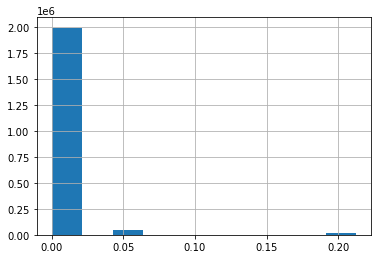

In [64]:
%matplotlib inline
P19_Wholedat['aSyn_fluo'].hist(bins=10)

In [65]:
P19_aSyn_array = P19_Wholedat['aSyn_fluo'].to_numpy(copy=True)

In [66]:
np.histogram(P19_aSyn_array)

(array([1997398,       0,   46872,       0,       0,       0,       0,
              0,       0,   16370]),
 array([0.     , 0.02125, 0.0425 , 0.06375, 0.085  , 0.10625, 0.1275 ,
        0.14875, 0.17   , 0.19125, 0.2125 ]))

In [67]:
P19_S6_C16_Wholedat['aSyn_fluo'].max(axis=0)

0.2125

In [69]:
P19_Wholedat['aSyn_fluo'].max(axis=0)

0.2125

In [70]:
P22_aSyn_array = P22_S14_C29_Wholedat['aSyn_fluo'].to_numpy(copy=True)


In [71]:
np.histogram(P22_aSyn_array, bins=200)

(array([6277429,       0,       0,       0,       0,       0,       0,
           9188,       0,       0,       0,       0,       0,       0,
           2514,       0,       0,       0,       0,       0,       0,
           1049,       0,       0,       0,       0,       0,       0,
            439,       0,       0,       0,       0,       0,       0,
            296,       0,       0,       0,       0,       0,       0,
            185,       0,       0,       0,       0,       0,       0,
            108,       0,       0,       0,       0,       0,       0,
             68,       0,       0,       0,       0,       0,       0,
              0,      37,       0,       0,       0,       0,       0,
              0,      39,       0,       0,       0,       0,       0,
              0,      17,       0,       0,       0,       0,       0,
              0,      17,       0,       0,       0,       0,       0,
              0,      13,       0,       0,       0,       0,       0,
      

In [73]:
P19_S6_C6_aSyn_array = P19_Wholedat['aSyn_fluo'].to_numpy(copy=True)

In [74]:
np.histogram(P19_S6_C6_aSyn_array, bins=100)

(array([1997398,       0,       0,       0,       0,       0,       0,
              0,       0,       0,       0,       0,       0,       0,
              0,       0,       0,       0,       0,       0,       0,
              0,       0,       0,       0,       0,       0,       0,
          46872,       0,       0,       0,       0,       0,       0,
              0,       0,       0,       0,       0,       0,       0,
              0,       0,       0,       0,       0,       0,       0,
              0,       0,       0,       0,       0,       0,       0,
              0,       0,       0,       0,       0,       0,       0,
              0,       0,       0,       0,       0,       0,       0,
              0,       0,       0,       0,       0,       0,       0,
              0,       0,       0,       0,       0,       0,       0,
              0,       0,       0,       0,       0,       0,       0,
              0,       0,       0,       0,       0,       0,       0,
      

In [75]:
P109_aSyn_array = P109C_Wholedat['aSyn_fluo'].to_numpy(copy=True)

In [76]:
np.histogram(P109_aSyn_array, bins=250)

(array([5129030,       0,   17083,       0,       0,    7519,       0,
              0,    4166,       0,       0,    2342,       0,       0,
           1420,       0,     838,       0,       0,     573,       0,
              0,     232,       0,       0,     116,       0,       0,
             65,       0,      50,       0,       0,      41,       0,
              0,      30,       0,       0,      25,       0,       0,
             14,       0,       8,       0,       0,       7,       0,
              0,      16,       0,       0,       8,       0,       0,
              7,       0,       4,       0,       0,       6,       0,
              0,       6,       0,       0,       3,       0,       0,
              0,       0,       0,       3,       0,       0,       0,
              0,       3,       0,       0,       2,       0,       0,
              3,       0,       0,       3,       0,       7,       0,
              0,       3,       0,       0,       2,       0,       0,
      

In [77]:
P17_aSyn_array = P17_Wholedat['aSyn_fluo'].to_numpy(copy=True)

In [78]:
np.histogram(P17_aSyn_array, bins=250)

(array([7054150,       0,       0,       0,       0,  228788,       0,
              0,       0,       0,   55624,       0,       0,       0,
              0,   28985,       0,       0,       0,       0,       0,
          19228,       0,       0,       0,       0,   13076,       0,
              0,       0,       0,    8862,       0,       0,       0,
              0,       0,    4930,       0,       0,       0,       0,
           3389,       0,       0,       0,       0,    2541,       0,
              0,       0,       0,       0,    1394,       0,       0,
              0,       0,    1004,       0,       0,       0,       0,
            856,       0,       0,       0,       0,       0,     476,
              0,       0,       0,       0,     320,       0,       0,
              0,       0,     292,       0,       0,       0,       0,
              0,     178,       0,       0,       0,       0,     511,
              0,       0,       0,       0,     311,       0,       0,
      

In [79]:
Thresh = 0.0007

In [80]:
def Dataframe_Thresholder(Input_df, Threshold):
    
    Masking_high = Input_df['aSyn_fluo'].mask(Input_df['aSyn_fluo']>=Threshold, 1)
    print(Input_df.shape)
    Masking_high_and_low = Masking_high.mask(Masking_high<Thresh, 0)
    Input_df['aSyn_fluo'] = Masking_high_and_low
    Mod_df = Input_df
    print(Mod_df.shape)
    
    return(Mod_df)

In [82]:
P19_S6_C6_bin_DF = Dataframe_Thresholder(P19_Wholedat, Thresh)

(2060640, 59)
(2060640, 59)


In [83]:
P22_S14_C29_bin_DF = Dataframe_Thresholder(P22_S14_C29_Wholedat, Thresh)

(6291456, 70)
(6291456, 70)


In [84]:
P109C_bin_DF = Dataframe_Thresholder(P109C_Wholedat, Thresh)

(5163674, 70)
(5163674, 70)


In [85]:
P17_bin_DF = Dataframe_Thresholder(P17_Wholedat, Thresh)

(7425372, 66)
(7425372, 66)


In [86]:
Pickler(P19_S6_C6_bin_DF,'/bph/puredata1/bioinfdata/user/phikie/Big_data_set_creation/Dataframes/Thresholded_df/P19_S6_C6/P19_S6_C6_SMALL')

In [87]:
Pickler(P22_S14_C29_bin_DF, '/bph/puredata1/bioinfdata/user/phikie/Big_data_set_creation/Dataframes/Thresholded_df/P22_S14_C29/P22_S14_C19_SMALL')

In [88]:
Pickler(P109C_bin_DF, '/bph/puredata1/bioinfdata/user/phikie/Big_data_set_creation/Dataframes/Thresholded_df/P109C/P109C_SMALL')

In [89]:
Pickler(P17_bin_DF, '/bph/puredata1/bioinfdata/user/phikie/Big_data_set_creation/Dataframes/Thresholded_df/P17/P17_SMALL')

In [97]:
def Sampler(DF_raw, ratio=np.array([0.7, 0.2, 0.1]), random_state=42):
    
    DF = DF_raw.reset_index(drop=True)
    DF_len = DF.shape[0]
    Train_frac = DF_len*ratio[0]
    Val_frac = DF_len*ratio[1]
    Test_frac = DF_len*ratio[2]
    
    def Ratiomaker(DF):
        
    
        #Count the number of 0 and 1 occurring under the column 'aSyn_fluo'

        value_count = DF['aSyn_fluo'].value_counts()
        Zeroes = value_count[0]
        Ones = value_count[1]

        #Ratio between 1 and Zero

        Ratio = Ones/Zeroes

        print('The ratio between fluorescent and non-fluorescent values is: '+str(Ratio))
        
        return()
        
              
    #Execute Ratio_maker to view the natural occurence of the 1/0 occurrence in the dataset          
    #Ratio_maker(DF)
    
    Test_sample = DF.sample((int(Test_frac)-10), replace=False, random_state=random_state)
    Test_indices = list(Test_sample.index)
    
    print('Finished with test_sample')
    print('Test_indices has this number of elements:' + str(len(Test_indices)))
              
    #Determine the dataset without the test set
              
    Resid_DF = DF.drop(Test_indices)
    print('Resid_DF_shape:' + str(Resid_DF.shape))
          
    print('Train_frac has this number of elements:' + str(Train_frac))
    
    Train_sample = Resid_DF.sample((int(Train_frac)-10), replace=False, random_state=random_state)
    Train_indices = list(Train_sample.index)
    
    print('Finished with train_sample')
              
    Val_sample = Resid_DF.drop(Train_indices)
    Val_indices = list(Val_sample.index)
    
    print('Finished with val_sample')
    
    print('Ratio DF: ')          
    Ratiomaker(DF)
    print('Ratio Train set: ')          
    Ratiomaker(Train_sample)
    print('Ratio Validation set: ')          
    Ratiomaker(Val_sample)
    print('Ratio Test set: ')          
    Ratiomaker(Test_sample)
              
    return(Train_sample, Val_sample, Test_sample)


In [98]:
P17_train, P17_val, P17_test = Sampler(P17_bin_DF)

Finished with test_sample
Test_indices has this number of elements:742527
Resid_DF_shape:(6682845, 66)
Train_frac has this number of elements:5197760.399999999
Finished with train_sample
Finished with val_sample
Ratio DF: 
The ratio between fluorescent and non-fluorescent values is: 0.05262462522061481
Ratio Train set: 
The ratio between fluorescent and non-fluorescent values is: 0.05265236397438922
Ratio Validation set: 
The ratio between fluorescent and non-fluorescent values is: 0.052613113231953446
Ratio Test set: 
The ratio between fluorescent and non-fluorescent values is: 0.052453509468193674


In [99]:
P19_train, P19_val, P19_test = Sampler(P19_S6_C6_bin_DF)

Finished with test_sample
Test_indices has this number of elements:206054
Resid_DF_shape:(1854586, 59)
Train_frac has this number of elements:1442448.0
Finished with train_sample
Finished with val_sample
Ratio DF: 
The ratio between fluorescent and non-fluorescent values is: 0.031662192512458706
Ratio Train set: 
The ratio between fluorescent and non-fluorescent values is: 0.03172410833389958
Ratio Validation set: 
The ratio between fluorescent and non-fluorescent values is: 0.03134462066652987
Ratio Test set: 
The ratio between fluorescent and non-fluorescent values is: 0.03186423023571418


In [100]:
P22_train, P22_val, P22_test = Sampler(P22_S14_C29_bin_DF)

Finished with test_sample
Test_indices has this number of elements:629135
Resid_DF_shape:(5662321, 70)
Train_frac has this number of elements:4404019.199999999
Finished with train_sample
Finished with val_sample
Ratio DF: 
The ratio between fluorescent and non-fluorescent values is: 0.0022345135245655508
Ratio Train set: 
The ratio between fluorescent and non-fluorescent values is: 0.0022327168689257972
Ratio Validation set: 
The ratio between fluorescent and non-fluorescent values is: 0.002232560658665131
Ratio Test set: 
The ratio between fluorescent and non-fluorescent values is: 0.002250996460216465


In [101]:
P109C_train, P109C_val, P109C_test = Sampler(P109C_bin_DF)

Finished with test_sample
Test_indices has this number of elements:516357
Resid_DF_shape:(4647317, 70)
Train_frac has this number of elements:3614571.8
Finished with train_sample
Finished with val_sample
Ratio DF: 
The ratio between fluorescent and non-fluorescent values is: 0.006754493539714137
Ratio Train set: 
The ratio between fluorescent and non-fluorescent values is: 0.006754289530906932
Ratio Validation set: 
The ratio between fluorescent and non-fluorescent values is: 0.006736885201955461
Ratio Test set: 
The ratio between fluorescent and non-fluorescent values is: 0.006791141683922367


In [102]:
Pickler(P17_train, '/bph/puredata1/bioinfdata/user/phikie/Big_data_set_creation/Split_dfs/P17/P17_train_SMALL')
Pickler(P17_val, '/bph/puredata1/bioinfdata/user/phikie/Big_data_set_creation/Split_dfs/P17/P17_val_SMALL')
Pickler(P17_test, '/bph/puredata1/bioinfdata/user/phikie/Big_data_set_creation/Split_dfs/P17/P17_test_SMALL')


In [103]:
Pickler(P19_train, '/bph/puredata1/bioinfdata/user/phikie/Big_data_set_creation/Split_dfs/P19/P19_train_SMALL')
Pickler(P19_val, '/bph/puredata1/bioinfdata/user/phikie/Big_data_set_creation/Split_dfs/P19/P19_val_SMALL')
Pickler(P19_test, '/bph/puredata1/bioinfdata/user/phikie/Big_data_set_creation/Split_dfs/P19/P19_test_SMALL')

In [104]:
Pickler(P22_train, '/bph/puredata1/bioinfdata/user/phikie/Big_data_set_creation/Split_dfs/P22/P22_train_SMALL')
Pickler(P22_val, '/bph/puredata1/bioinfdata/user/phikie/Big_data_set_creation/Split_dfs/P22/P22_val_SMALL')
Pickler(P22_test, '/bph/puredata1/bioinfdata/user/phikie/Big_data_set_creation/Split_dfs/P22/P22_test_SMALL')

In [105]:
Pickler(P109C_train, '/bph/puredata1/bioinfdata/user/phikie/Big_data_set_creation/Split_dfs/P109C/P109_train_SMALL')
Pickler(P109C_val, '/bph/puredata1/bioinfdata/user/phikie/Big_data_set_creation/Split_dfs/P109C/P109_val_SMALL')
Pickler(P109C_test, '/bph/puredata1/bioinfdata/user/phikie/Big_data_set_creation/Split_dfs/P109C/P109_test_SMALL')